# Extract data from jsons and insert into CSV

In [1]:
import os
import csv
import json


folder_path = '../receipts/json'

items = []

for file in os.listdir(folder_path):
    receipt_path = os.path.join(folder_path, file)

    with open(receipt_path) as receipt_data:
        receipt = json.load(receipt_data)

    item_list = receipt['itemList'] + receipt['discountList']

    for item in item_list:
        items.append([receipt['storeName'],item['itemName'],item['category']])

with open('../receipts/categories.csv', 'w', newline='') as file:
    header = [['store_name', 'item_name', 'category']]
    writer = csv.writer(file)
    writer.writerows(header+items)


# Clean and prep data

In [2]:
import pandas as pd
import string

def lower(text):
    result = " ".join([word.lower() for word in text.split()])
    return result

def remove_punctuation(product):
    text = str.maketrans((string.punctuation + '£'), ' '*len((string.punctuation + '£')))
    return product.translate(text)

def remove_nums(product):
    text = str.maketrans(string.digits, ' '*len(string.digits))
    return product.translate(text)

In [3]:
path = '../receipts/categories.csv'
dataset = pd.read_csv(path, header=0, index_col=0)

dataset = dataset.sample(657).reset_index()

print(dataset.shape)
dataset.head(10)

(657, 3)


,store_name,item_name,category
0,WAITROSE & PARTNERS,GRESS SPATCHCOCK,groceries
1,TESCO,CC Pizza,groceries
2,TESCO,BACON RASHERS,groceries
3,LiDL,Asparagus Tips,groceries
4,Simply Fresh,STRAWBERRY TWISTS,snacks
5,TESCO,CC Potato shapes,groceries
6,TESCO,CARTRIDGES,electrical
7,LiDL,MarbleBriocheVanilla,groceries
8,TESCO,FRESH MILK,groceries
9,TESCO,SAUSAGES,groceries


## NLTK preprocesing

In [4]:
stop = ['cc', 'wr', 'tesco', 'aa', 'ess']

units_solid = ['kg', 'g', 'gram', 'grams']
units_liquid = ['ml', 'l', 'cl', 'ltr']
units_length = ['m', 'mm', 'cm', 'km', 'metre']
units = ['pk', 'sm', 'lg', 'large', 'extra', 'sng']

def remove_stopwords(text):
    text = [word for word in text.split() if (word.lower() not in stop and len(word) > 1)]
    return " ".join(text)

def replace_units(text):
    words = []
    for word in text.split():
        if word in units_solid:
            words.append('<UNIT_SOLID>')
        elif word in units_liquid:
            words.append('<UNIT_LIQUID>')
        elif word in units:
            words.append('<UNIT>')
        else:
            words.append(word)
    return " ".join(words)

dataset['item_name'] = dataset['item_name'].astype(str)
dataset['item_name'] = dataset['item_name'].apply(lower)
dataset['item_name'] = dataset['item_name'].apply(remove_punctuation)
dataset['item_name'] = dataset['item_name'].apply(remove_nums)
dataset['item_name'] = dataset['item_name'].apply(replace_units)
dataset['item_name'] = dataset['item_name'].apply(remove_stopwords)

dataset['store_name'] = dataset['store_name'].astype(str)
dataset['store_name'] = dataset['store_name'].apply(lower)
dataset['store_name'] = dataset['store_name'].apply(remove_punctuation)

print(dataset.head(10))

            store_name             item_name    category
0  waitrose   partners      gress spatchcock   groceries
1                tesco                 pizza   groceries
2                tesco         bacon rashers   groceries
3                 lidl        asparagus tips   groceries
4         simply fresh     strawberry twists      snacks
5                tesco         potato shapes   groceries
6                tesco            cartridges  electrical
7                 lidl  marblebriochevanilla   groceries
8                tesco            fresh milk   groceries
9                tesco              sausages   groceries


In [5]:
data = dataset.to_csv('../receipts/products_list_final.csv', encoding='utf-8')

In [6]:
custom_data = pd.read_csv("../receipts/products_list_final.csv", index_col=0, header=0, names=["store_name", "item_name", "category"])
custom_labels = custom_data.category.unique()

In [7]:
custom_data

,store_name,item_name,category
0,waitrose partners,gress spatchcock,groceries
1,tesco,pizza,groceries
2,tesco,bacon rashers,groceries
3,lidl,asparagus tips,groceries
4,simply fresh,strawberry twists,snacks
...,...,...,...
652,tesco,range eggs,groceries
653,house of fraser,nicce expo jkt sn,clothes & accessories
654,tesco,ginger cake,snacks
655,tesco,bread,groceries


In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import np_utils
from keras.layers import TextVectorization
import keras.layers as l
import tensorflow as tf
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath

from keras.models import Sequential

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mc = ModelCheckpoint(
    'final.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

es = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=100,
    mode='auto'
)

rlr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=50,
    min_delta=0.001,
    verbose=1, 
    mode='auto'
)

callbacks = [mc, es, rlr]

def split_dataset(df):
    train, test, x2train, x2test, ytrain, ytest = train_test_split(df['item_name'].astype(str), df['store_name'], df['category'], test_size=0.15, random_state=69)

    return train, test, x2train, x2test, ytrain, ytest
    

def create_one_hot_labels(Y_train, Y_test, labels):
    encoder = LabelEncoder()
    encoder.fit(labels)

    Y_train = encoder.transform(Y_train)
    Y_test = encoder.transform(Y_test)

    n_classes = np.max(Y_train) + 1

    Y_train = np_utils.to_categorical(Y_train, n_classes)
    Y_test = np_utils.to_categorical(Y_test, n_classes)

    return Y_train, Y_test, n_classes, encoder


def get_max_len(df):
    idx = df['item_name'].str.len().idxmax()
    print(idx)

    max_len = len(df["item_name"][idx])

    if max_len > 450:
        max_len = 500
    else:
        max_len += 50

    return max_len


def get_vectors(df, X_train, X_test, max_len):
    vectorizer = TextVectorization(output_sequence_length=max_len)

    vectorizer.adapt(df['item_name'])

    vocab = vectorizer.get_vocabulary()

    word_index = dict(zip(vocab, range(len(vocab))))

    X_train = vectorizer(X_train)
    X_test = vectorizer(X_test)

    return X_train, X_test, vocab, word_index, vectorizer


def get_embedding_model(matrix, n_tokens, max_len, n_classes, dim=100, lr=0.0003):
    embedding_layer = l.Embedding(
    n_tokens,
    dim,
    input_length=max_len,
    embeddings_initializer=tf.keras.initializers.Constant(matrix),
    trainable=True
    )

    embedding_model = Sequential()
    embedding_model.add(embedding_layer)
    embedding_model.add(l.GlobalMaxPooling1D()) # Turn 2D output into 1D for dense layers

    embedding_model.add(l.Dense(n_classes, activation='softmax'))

    optim = tf.keras.optimizers.Adam(learning_rate=lr)

    embedding_model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return embedding_model


def get_model_acc(X_train, X_test, Y_train, Y_test, model, n_epochs=1000):
    history = model.fit(X_train, Y_train, batch_size=25, epochs=n_epochs, validation_data=(X_test, Y_test), callbacks=callbacks)
    metrics = [[history.history['val_accuracy'][-1], history.history['val_loss'][-1]]]
    
    metrics = pd.DataFrame(metrics, columns=['val_accuracy', 'val_loss'])
    return metrics, history


def train_ft(df):
    cor_path = datapath("lee_background.cor")
    ft = FastText(vector_size=100)

    train_ft = df['item_name'].tolist()

    train_ft = [x.split() for x in train_ft]

    ft.build_vocab(corpus_file=cor_path)

    ft.train(
        corpus_file=cor_path, epochs=ft.epochs,
        total_examples=ft.corpus_count, total_words=ft.corpus_total_words,
    )

    ft.build_vocab(train_ft, update=True)
    ft.train(train_ft, total_examples=len(train_ft), epochs=ft.epochs)

    return ft


def get_ft_matrix(vocab, word_index, ft):
    n_tokens = len(vocab) + 2
    embedding_dim = 100
    hits = 0
    misses = 0

    matrix = np.zeros((n_tokens, embedding_dim))

    for word, i in word_index.items():
        try:
            embedding_vector = ft.wv[word]

            if embedding_vector is not None:
                matrix[i] = embedding_vector
                hits += 1
            else:
                matrix[i] = np.random.randn(embedding_dim)
                misses += 1
        except Exception as e:
            matrix[i] = np.random.randn(embedding_dim)
            print(e)
            misses += 1

    print("Converted %d words (%d misses)" % (hits, misses))

    return matrix, n_tokens

In [19]:
import matplotlib.pyplot as plt
def train_val_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])

    plt.title(f'History of {metric} over epochs')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['training '+metric, 'validation '+metric])

    plt.show()

In [20]:
custom_stores = custom_data.store_name.unique()

In [21]:
custom_stores

array(['waitrose   partners', 'tesco', 'lidl', 'simply fresh', 'oxfam',
       'sainsbury s', 'sushi jun', 't k maxx', 't4', 'osprey london',
       'aldi', 'www itsu com', 'kenji', 'greggs', 'b m', 'aldi stores',
       'tea terrace', 'poundland', 'taco bell', 'costa',
       'whlung supermarket', 'vapouriz', 'bodycare', 'uniqlo', 'evapo',
       'blue bear bookshop', 'co op', 'uber eats', 'currys pc world',
       't a shake shack', 'house of fraser', 'boots uk limited'],
      dtype=object)

In [22]:
def load_stores(X2_train, X2_test, stores):
    encoder = LabelEncoder()
    encoder.fit(stores)

    X2_train = encoder.transform(X2_train)
    X2_test = encoder.transform(X2_test)

    n_stores = np.max(X2_train) + 1

    X2_train = np_utils.to_categorical(X2_train, n_stores)
    X2_test = np_utils.to_categorical(X2_test, n_stores)

    stores_shape = len(X2_train[0])

    return X2_train, X2_test, stores_shape

In [23]:
def get_store_vectors(df, X2_train, X2_test, max_len):
    vectorizer = TextVectorization(output_sequence_length=max_len)

    vectorizer.adapt(df['store_name'])

    vocab = vectorizer.get_vocabulary()

    word_index = dict(zip(vocab, range(len(vocab))))

    X2_train = vectorizer(X2_train)
    X2_test = vectorizer(X2_test)

    print(len(X2_train[0]))

    return X2_train, X2_test, vocab, word_index, vectorizer

In [24]:
def get_textcnn2_model(matrix, n_tokens, store_tokens, max_len, n_classes, dim=100):
    product_inputs = tf.keras.Input(shape=(max_len,))
    store_inputs = tf.keras.Input(shape=(50,))   

    product_embedding = l.Embedding(
        n_tokens,
        dim,
        input_length=max_len,
        embeddings_initializer=tf.keras.initializers.Constant(matrix),
        trainable = True
    )(product_inputs)

    store_embedding = l.Embedding(
        store_tokens,
        dim,
        input_length=50,
        trainable = True
    )(store_inputs)

    reshape = l.Reshape((max_len, 100, 1))(product_embedding)
    pooled = l.GlobalMaxPooling1D()(store_embedding)

    conv_0 = l.Conv2D(100, kernel_size=(3,100), activation='relu')(reshape)
    conv_1 = l.Conv2D(100, kernel_size=(4,100), activation='relu')(reshape)
    conv_2 = l.Conv2D(100, kernel_size=(5,100), activation='relu')(reshape)

    maxpool_0 = l.MaxPooling2D(pool_size=(max_len - 3 + 1, 1))(conv_0)
    maxpool_1 = l.MaxPooling2D(pool_size=(max_len - 4 + 1, 1))(conv_1)
    maxpool_2 = l.MaxPooling2D(pool_size=(max_len - 5 + 1, 1))(conv_2)

    concatenate = l.Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])

    flatten = l.Flatten()(concatenate)

    concatenate = l.Concatenate(axis=1)([flatten,pooled])

    dropout = l.Dropout(0.5)(concatenate)

    dense1 = l.Dense(128, activation='relu')(dropout)

    dropout2 = l.Dropout(0.5)(dense1)

    output = l.Dense(n_classes, activation='softmax')(dropout2)

    embedding_model = tf.keras.Model(inputs=[product_inputs, store_inputs], outputs=output)

    optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

    embedding_model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return embedding_model

In [25]:
def get_model_acc2(X_train, X_test, X2_train, X2_test, Y_train, Y_test, model, n_epochs=1000):
    history = model.fit([X_train, X2_train],Y_train, batch_size=25, epochs=n_epochs, validation_data=([X_test, X2_test], Y_test), callbacks=callbacks)
    metrics = [[history.history['val_accuracy'][-1], history.history['val_loss'][-1]]]
    
    metrics = pd.DataFrame(metrics, columns=['val_accuracy', 'val_loss'])
    return metrics, history

In [26]:
def run_storedata(df, labels):
    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, X2_train, X2_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes, encoder = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)
    print(max_len)

    X_train, X_test, vocab, word_index, vectoriser = get_vectors(df, X_train, X_test, max_len)
    X2_train, X2_test, store_vocab, _, store_vectoriser = get_store_vectors(df, X2_train, X2_test, max_len=50)

    ft_embeddings = train_ft(df)

    ft_matrix, n_tokens = get_ft_matrix(vocab, word_index, ft_embeddings)

    store_tokens = len(store_vocab)

    print(n_tokens, max_len)

    model = get_textcnn2_model(ft_matrix, n_tokens, store_tokens, max_len, n_classes)
    
    metrics, history = get_model_acc2(X_train, X_test, X2_train, X2_test, Y_train, Y_test, model)
    
    return metrics, history, model, encoder, vectoriser, store_vectoriser

322
120
50
Converted 669 words (0 misses)
671 120
Epoch 1/1000
23/23 [==============================] - 1s 21ms/step - loss: 2.7297 - accuracy: 0.2563 - val_loss: 2.6650 - val_accuracy: 0.4646 - lr: 1.0000e-04
Epoch 2/1000
23/23 [==============================] - 0s 9ms/step - loss: 2.5969 - accuracy: 0.5108 - val_loss: 2.5029 - val_accuracy: 0.4747 - lr: 1.0000e-04
Epoch 3/1000
23/23 [==============================] - 0s 6ms/step - loss: 2.4354 - accuracy: 0.5287 - val_loss: 2.3184 - val_accuracy: 0.4747 - lr: 1.0000e-04
Epoch 4/1000
23/23 [==============================] - 0s 6ms/step - loss: 2.2621 - accuracy: 0.5305 - val_loss: 2.1617 - val_accuracy: 0.4747 - lr: 1.0000e-04
Epoch 5/1000
23/23 [==============================] - 0s 6ms/step - loss: 2.1307 - accuracy: 0.5269 - val_loss: 2.0607 - val_accuracy: 0.4747 - lr: 1.0000e-04
Epoch 6/1000
23/23 [==============================] - 0s 6ms/step - loss: 2.0617 - accuracy: 0.5269 - val_loss: 1.9959 - val_accuracy: 0.4747 - lr: 1.0000

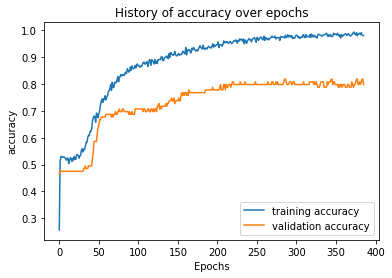

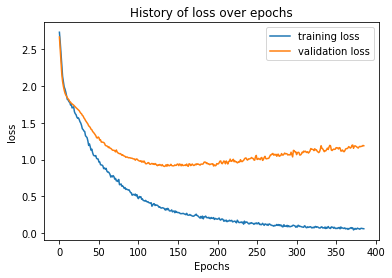

In [55]:
metrics, history, model, encoder, vectoriser, store_vectoriser = run_storedata(custom_data, custom_labels)

train_val_graph(history, "accuracy")
train_val_graph(history, "loss")

In [40]:
import pickle

In [49]:
pickle.dump(encoder, open("encoder.pickle", "wb"))

In [50]:
pickle.dump({'config': vectoriser.get_config(), 'weights': vectoriser.get_weights()}, open("vectorconfig.pkl", "wb"))

In [51]:
pickle.dump({'config': store_vectoriser.get_config(), 'weights': store_vectoriser.get_weights()}, open("storeconfig.pkl", "wb"))

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
from keras.models import load_model
K.clear_session()
model = load_model('final.h5')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 120, 100)     67100       ['input_3[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 120, 100, 1)  0           ['embedding_2[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)              (None, 118, 1, 100)  30100       ['reshape_1[0][0]']              
                                                                                            

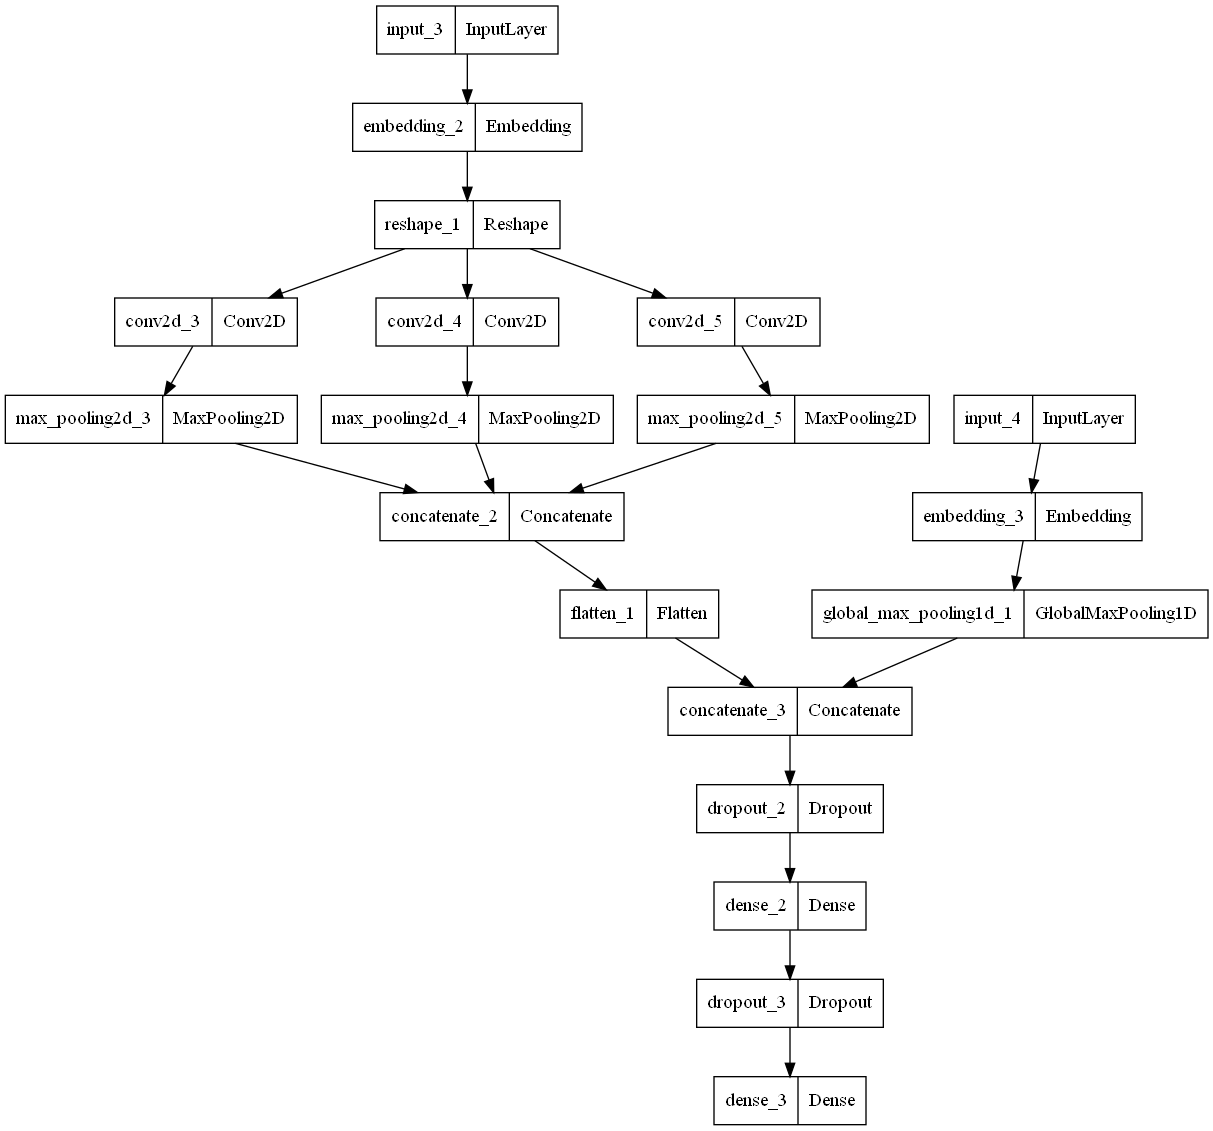

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
items = [
    ['fried chicken'],
    ['poems'],
    ['biscuits'],
    ['ice cream'],
    ['vodka'],
    ['lemon tea'],
    ['lemon iced tea'],
    ['lemon ice tea'],
    ['fried chicken'],
    ['poems'],
    ['biscuits'],
    ['ice cream'],
    ['vodka'],
    ['lemon tea'],
    ['lemon iced tea'],
    ['lemon ice tea']
    ]
    
stores = [
    ['t4'],
    ['book shop'],
    ['tesco'],
    ['tesco'],
    ['sainsburys'],
    ['aldi'],
    ['lidl'],
    ['t4'],
    ['tesco'],
    ['tesco'],
    ['sainsburys'],
    ['asda'],
    ['tesco'],
    ['tesco'],
    ['tesco'],
    ['tesco']
    ]

In [ ]:
product_string = tf.keras.Input(shape=(1,), dtype="string")
store_string = tf.keras.Input(shape=(1,), dtype="string")

x = vectoriser(product_string)
x2 = store_vectoriser(store_string)

class_names= encoder.classes_

predictions = model([x, x2])


e2e_model = tf.keras.Model([product_string, store_string], predictions)

#e2e_model.summary()

products_input = tf.convert_to_tensor(items)
store_input = tf.convert_to_tensor(stores)


probabilities = e2e_model.predict([products_input, store_input])

for i in tf.range(len(probabilities)):
    print("'"+products_input.numpy()[i][0].decode('UTF-8') + "' from '" + store_input.numpy()[i][0].decode('UTF-8') + "' is labelled with the category \"" + class_names[np.argmax(probabilities[i])] + "\" with " + str(float('{0:.2f}'.format(np.max(probabilities[i])*100))) + "% certainty")

'fried chicken' from 't4' is labelled with the category "eating out" with 80.56% certainty
'poems' from 'book shop' is labelled with the category "snacks" with 20.78% certainty
'biscuits' from 'tesco' is labelled with the category "snacks" with 98.2% certainty
'ice cream' from 'tesco' is labelled with the category "snacks" with 99.98% certainty
'vodka' from 'sainsburys' is labelled with the category "snacks" with 20.78% certainty
'lemon tea' from 'aldi' is labelled with the category "drinks" with 99.64% certainty
'lemon iced tea' from 'lidl' is labelled with the category "drinks" with 99.93% certainty
'lemon ice tea' from 't4' is labelled with the category "drinks" with 96.87% certainty
'fried chicken' from 'tesco' is labelled with the category "groceries" with 93.39% certainty
'poems' from 'tesco' is labelled with the category "snacks" with 62.55% certainty
'biscuits' from 'sainsburys' is labelled with the category "snacks" with 91.87% certainty
'ice cream' from 'asda' is labelled wit